In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
import re
import os
import seaborn as sns
from matplotlib import cm, colors

In [2]:
merged_df = pd.read_csv(r'aux_file\data_regression.csv')

In [3]:
obj_params = pd.read_excel('voces_test_rms.ods')

In [4]:
obj_params.head()

,zero_crossing_rate,rms,mfcc,pitch,genero,file
0,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino,hyacinthe-lovo-v3.wav
1,0.093035,-27.0,[-424.61664 138.61742 -14.495688 3...,101.312090,femenino,lola-murf.wav
2,0.093043,-22.5,[-3.71418152e+02 1.31561859e+02 -1.60284328e+...,76.492752,masculino,neural2B-GCP.wav
3,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino,alonso-naturalreader.wav
4,0.105458,-21.5,[-3.5115176e+02 1.1943483e+02 -1.9279911e+01 ...,69.045778,masculino,antonio-murf.wav


In [5]:
df_union = pd.merge(
    merged_df,
    obj_params,
    how='left',
    left_on='filename',
    right_on='file'
).drop(columns=['file'])

In [6]:
df_union.rename(
    columns={
        'zero_crossing_rate': 'zcr',
        'pitch': 'f0'
    },
    inplace=True
)

In [7]:
df_union.head()

,ID,filename,Inteligibilidad,Pronunciacion,Acentuacion,Naturalidad,Cadencia,zcr,rms,mfcc,f0,genero
0,1,alonso-naturalreader.wav,4.900000,4.641026,4.500,2.925,3.900,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino
1,2,hyacinthe-lovo-v3.wav,4.975000,4.641026,4.525,4.100,4.175,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino
2,3,neural2C-pitchmodified-speedmodified.wav,4.447368,3.882353,2.900,1.675,1.675,0.251626,-25.0,[-4.4141333e+02 8.9362648e+01 -1.2164741e+01 ...,98.468505,masculino
3,4,francisca-lovo-v2.wav,4.625000,4.297297,4.225,2.975,3.750,0.137822,-26.1,[-454.8679 72.41395 -14.8625145 45.9...,116.353345,femenino
4,5,antoni-evenlabs-linguistico-v2.wav,4.550000,4.142857,3.200,1.825,1.600,0.239188,-24.0,[-406.19888 84.30505 -12.89493 18.8...,78.968152,masculino


## SelectorFeature

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.utils import check_random_state
from sklearn.model_selection import permutation_test_score
from sklearn.svm import SVR

### Inteligibilidad

In [9]:
df_inteligibilidad = df_union.loc[:, ['Inteligibilidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [10]:
mask_gender = df_inteligibilidad.genero == 'masculino'

df_inteligibilidad_male = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [11]:
# Cargamos los datos
X = np.array(df_inteligibilidad_male.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_male.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (2,)


In [12]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    print(f'{var} p-valor:', pvalue)


ZCR p-valor: 0.008991008991008992
RMS p-valor: 0.14485514485514486
f0 p-valor: 0.08491508491508491


In [13]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [23]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.02 * $f_{0}$ + 5.86 - p-valor = 0.085


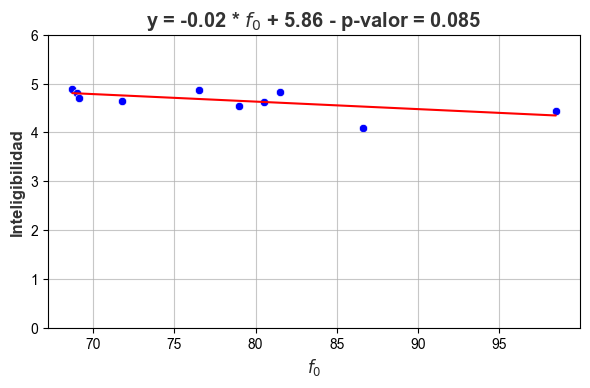

In [24]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    # plt.savefig(os.path.join(PATH, TEST_FOLDER, GRAPH_FOLDER, 'regresiones_inteligibilidad.png'))
    plt.show()


In [ ]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6])))

    # fig.write_html(os.path.join(PATH, TEST_FOLDER, GRAPH_FOLDER,'regresion_inteligibilidad_multivariable.html'))

    fig.show()


#### Femenino

In [29]:
mask_gender = df_inteligibilidad.genero == 'femenino'

df_inteligibilidad_female = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [30]:
# Cargamos los datos
X = np.array(df_inteligibilidad_female.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_female.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0, 1)


In [31]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    print(f'{var} p-valor:', pvalue)


ZCR p-valor: 0.04195804195804196
RMS p-valor: 0.04595404595404595
f0 p-valor: 0.2017982017982018


In [32]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [33]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.26 * ZCR + 4.78 - p-valor = 0.042
y = 0.10 * RMS + 7.50 - p-valor = 0.046


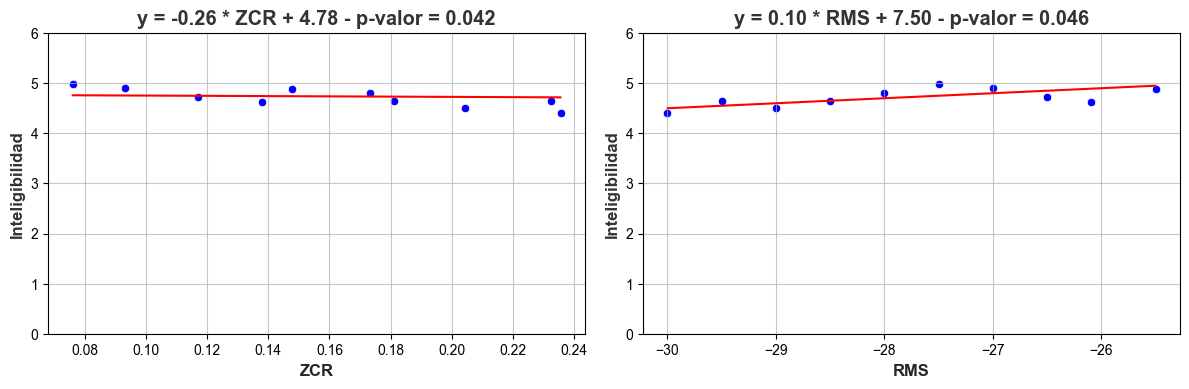

In [34]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    # plt.savefig(os.path.join(PATH, TEST_FOLDER, GRAPH_FOLDER, 'regresiones_inteligibilidad.png'))
    plt.show()


In [36]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    # fig.write_html(os.path.join(PATH, TEST_FOLDER, GRAPH_FOLDER,'regresion_inteligibilidad_multivariable.html'))

    fig.show()
